# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import numpy as np
import cv2
import tensorflow as tf
import random
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample

import pickle
from PIL import Image
from IPython.core.display import display
import numpy as np
import csv
import collections

In [2]:
# Load pickled data
training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
### To start off let's do a basic data summary.
# TODO: number of training examples
n_train = len(train['features'])

# TODO: number of testing examples
n_test = len(test['features'])

# TODO: what's the shape of an image?
image_shape = train['features'].shape

# TODO: how many classes are in the dataset
n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Number of classes = 43


In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

###Show Image and label of image
def show_image(image_number, color):
    data = X_train[image_number]
    img = Image.fromarray(data, color)
    img.show()

def show_label(image_number):
    label = y_train[image_number]
    with open('signnames.csv', newline='') as csvfile:
        signnames = list(csv.reader(csvfile))
        print(signnames[label+1])
        
image_number = 1000
show_image(image_number, 'RGB')
show_label(image_number)

['1', 'Speed limit (30km/h)']


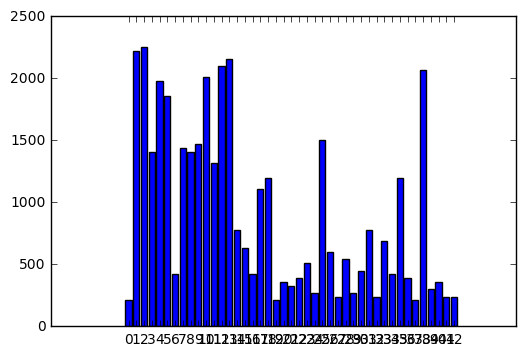

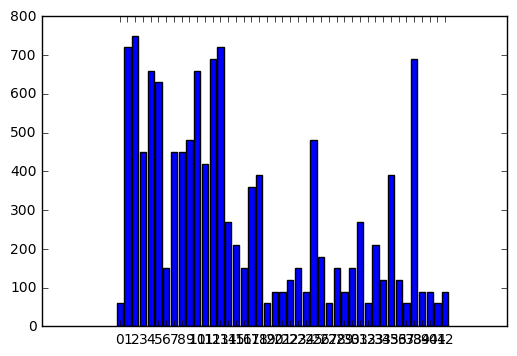

In [5]:
### Plotting Count of each sign:
def plot_sign_collection(signs):
    cnt = collections.Counter()
    for el in signs:
        cnt[el] += 1
    plt.bar(range(len(cnt)), cnt.values(), align='center')
    plt.xticks(range(len(cnt)), cnt.keys())
    plt.show()
    
plot_sign_collection(y_train)
plot_sign_collection(y_test)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Normalize
def normalize_image(img):
    return (((img) - 128.) / 128.)

normalized_train = normalize_image(X_train)
normalized_test = normalize_image(X_test)

### (OPTIONAL:) Use canny to detect shape of sign and normalize
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def add_canny_layer(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    canny_img = canny(gray, 50, 100)
    img_4d = np.insert(img, 3, [canny_img],axis=2)
    return img_4d

train_4d = []
for el in (X_train):
    img_4d = add_canny_layer(el)
    norm_img_4d = normalize_image(img_4d)
    train_4d.append(norm_img_4d)
    
test_4d = []
for el in (X_test):
    img_4d = add_canny_layer(el)
    norm_img_4d = normalize_image(img_4d)
    test_4d.append(norm_img_4d)

print('Normalized and added Canny_Edge_Layer')

Normalized and added Canny_Edge_Layer


In [7]:
# Apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(y_train)
train_labels = encoder.transform(y_train)
test_labels = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)
is_labels_encod = True

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

Normalization: Images with zero mean and in [-1.,1.]

Normalization speeds up the network performance because handling bigger numbers is avoided. Also biases and overfitting of hugh numbers is avoided.

One-Hot-Encoding: Turned traffic-sign-labels into one-hot-encoded vektors and changed to float32. So it can be multiplied against the festures in TensorFlow.

OPTIONAL: Canny_Edge_Transform: Added one more canny_Edge_detected layer to every picture (making it a 4D image).

The CannyEdge Layer is not in use, but the idea was, to recognize shapes of signs or numbers as a extra layer to speed up the learning algorithm.

In [8]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

train_features, valid_features, train_labels, valid_labels = train_test_split(
    normalized_train,
    train_labels,
    test_size=0.3)

print(len(train_features))
print(len(train_labels))

27446
27446


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

Used train_test_split()-method from sklearn.model_selection.

Splitted train_data into train/valid-data by 5%.

Testing data already exists in the Dataset, with a similar collection of traffic-signs.

In [9]:
### Define your architecture here.
### Feel free to use as many code cells as needed.


In [10]:
# Parameters
learning_rate = 0.05
batch_size = 100
training_epochs = 40

# Image Properties
image_width = 32
image_height = 32
color_channels = 3
#canny_img_channels = 4

n_classes = 43

layer_width = {
    'layer_1': 18,
    'layer_2': 36,
    'layer_3': 72,
    'fully_connected': 128
}

n_input = 4*4*layer_width['layer_3']

weights = {
    'layer_1': tf.Variable(tf.truncated_normal([3, 3, color_channels, layer_width['layer_1']], stddev=0.1)),
    'layer_2': tf.Variable(tf.truncated_normal([3, 3, layer_width['layer_1'], layer_width['layer_2']], stddev=0.1)),
    'layer_3': tf.Variable(tf.truncated_normal([3, 3, layer_width['layer_2'], layer_width['layer_3']], stddev=0.1)),
    'fully_connected': tf.Variable(tf.truncated_normal([n_input, layer_width['fully_connected']], stddev=0.1)),
    'out': tf.Variable(tf.truncated_normal([layer_width['fully_connected'], n_classes], stddev=0.1))
}
biases = {
    'layer_1': tf.Variable(tf.zeros(layer_width['layer_1'])),
    'layer_2': tf.Variable(tf.zeros(layer_width['layer_2'])),
    'layer_3': tf.Variable(tf.zeros(layer_width['layer_3'])),
    'fully_connected': tf.Variable(tf.zeros(layer_width['fully_connected'])),
    'out': tf.Variable(tf.zeros(n_classes))
}

In [11]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [12]:
def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

In [13]:
keep_prob = tf.placeholder(tf.float32)


def conv_net(x, weights, biases):
    # Layer 1
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
    conv1 = maxpool2d(conv1, k=2)

    # Layer 2
    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    conv2 = maxpool2d(conv2, k=2)
    
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # Layer 3
    conv3 = conv2d(conv2, weights['layer_3'], biases['layer_3'])
    conv3 = maxpool2d(conv3, k=2)

    # Fully connected layer
    # Reshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape(
        conv3,
        [-1, weights['fully_connected'].get_shape().as_list()[0]])
    fc1 = tf.add(
        tf.matmul(fc1, weights['fully_connected']),
        biases['fully_connected'])
    fc1 = tf.nn.relu(fc1)
    
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Output Layer - class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])

    return out

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

Type of Model:

- Convolutional Neural Network

Layer setting:

1. Convolutional Layer (3x3 sliding window 1x1 stride, followed by a Relu), Input (32x32x3 Image) / Output (32x32x18 Matrix)
2. MaxPool Layer (2x2 window 2x2 stride), Input (32x32x18 Matrix) / Output (16x16x18 Matrix)
3. Convolutional Layer (3x3 sliding window 1x1 stride, followed by a Relu), Input (16x16x18 Matrix) / Output (16x16x36 Matrix)
4. MaxPool Layer (2x2 window 2x2 stride), Input (16x16x36 Matrix) / Output (8x8x36 Matrix)
5. Dropout to avoid overfitting (keep probability 50%(train)/100%(perform)), Input/Output (8x8x36 Matrix)
6. Convolutional Layer (3x3 sliding window 1x1 stride, followed by a Relu), Input (8x8x36 Matrix) / Output (8x8x72 Matrix)
7. MaxPool Layer (2x2 window 2x2 stride), Input (8x8x72 Matrix) / Output (4x4x72 Matrix)
8. Flatten the output-matrix, Input (4x4x72 Matrix) / Output (1152x1 Vektor)
9. Fully connected layer (W*X + b, followed by a relu), Input (1152x1 Vektor) / Output (128x1 Vektor)
10. Dropout to avoid overfitting (keep probability 50%(train)/100%(perform)), Input/Output (128x1 Vektor)
11. Fully connected layer (W*X + b, followed by a relu), Input (128x1 Vektor) / Output (43x1 Vektor)
12. Outcome is a 43x1 vector based on the traffic-sign classes.

Parameter:

- Learning Rate = 0.05

- Batch Size = 100

- Epochs = 40

In [17]:
## Train your model here.
### Feel free to use as many code cells as needed.

x = tf.placeholder("float", [None, image_width, image_height, color_channels])
y = tf.placeholder("float", [None, n_classes])

logits = conv_net(x, weights, biases)
   
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
adam_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()

# Initialize the saver
saver = tf.train.Saver()

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    for epoch in range(training_epochs):
        #sess.run(optimizer,feed_dict={x: train_features, y: train_labels})
        total_batch = int(len(train_features)/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x = train_features[(i*batch_size):((i+1)*batch_size)]
            batch_y = train_labels[(i*batch_size):((i+1)*batch_size)]
            # Run optimization op (backprop) and cost op (to get loss value)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        # Display logs per epoch step
        c = sess.run(cost, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        a = sess.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.0})
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), "acc=", "{:.9f}".format(a))
    print("Optimization Finished!")

    # Calculate accuracy
    print(
        "Accuracy:",
        accuracy.eval(feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.0}))
    
    # Save the variables to disk.
    save_path = saver.save(sess, "./traffic-sign-model_v2.ckpt")
    print("Model saved in file: %s" % save_path)

Epoch: 0001 cost= 2.991212845 acc= 0.233613878
Epoch: 0002 cost= 2.191208124 acc= 0.374904364
Epoch: 0003 cost= 2.070714235 acc= 0.415455252
Epoch: 0004 cost= 1.688742161 acc= 0.499192387
Epoch: 0005 cost= 1.496827245 acc= 0.574088216
Epoch: 0006 cost= 1.330227971 acc= 0.652469635
Epoch: 0007 cost= 1.220965624 acc= 0.713423431
Epoch: 0008 cost= 1.115905881 acc= 0.747088313
Epoch: 0009 cost= 1.056160092 acc= 0.777267694
Epoch: 0010 cost= 0.830930769 acc= 0.815268219
Epoch: 0011 cost= 0.713622332 acc= 0.840431869
Epoch: 0012 cost= 0.767960310 acc= 0.853863835
Epoch: 0013 cost= 0.764698207 acc= 0.871716380
Epoch: 0014 cost= 0.743140280 acc= 0.880897701
Epoch: 0015 cost= 0.552263319 acc= 0.913457453
Epoch: 0016 cost= 0.623670340 acc= 0.918898225
Epoch: 0017 cost= 0.477367163 acc= 0.925614238
Epoch: 0018 cost= 0.550351322 acc= 0.944912016
Epoch: 0019 cost= 0.403846651 acc= 0.937515914
Epoch: 0020 cost= 0.540911078 acc= 0.940576375
Epoch: 0021 cost= 0.236268312 acc= 0.953413248
Epoch: 0022 c

In [18]:
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "./traffic-sign-model_v2.ckpt")
    print("Model restored.")
    
    # Calculate accuracy using the test_set
    print("Accuracy:", accuracy.eval(feed_dict={x: normalized_test, y: test_labels, keep_prob: 1.0}))


Model restored.
Accuracy: 0.947189


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

Type of Optimizer:

- Gradient Descent: Best Performance with current settings
- Adam Optimizer: Tested.

Batch Size = 100

Epochs = 40

Learning rate = 0.05

Use_Locking = False

keep_prob = 50% (train) / 100% (test)

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

Started with an easy one Layered Network, tested performance and made it deeper, till I was happy with the result.

The size of the sliding windows for the conv nets is based on the size of the picture and the sizes of parts I expect to be detected in a traffic-sign picture. Like Number-lines or -curves in a 32x32 speed-limit sign.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

['120_limit_1.jpg', '120_limit_2.jpg', '30_limit_1.jpg', '30_limit_2.jpg', '30_limit_3.jpg', '80_limit_1.jpg', '80_limit_2.jpg', 'achtung_1.jpg', 'achtung_2.jpg', 'fussgaenger_1.jpg']


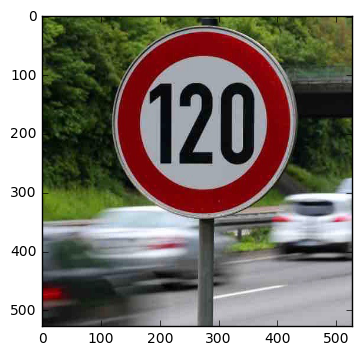

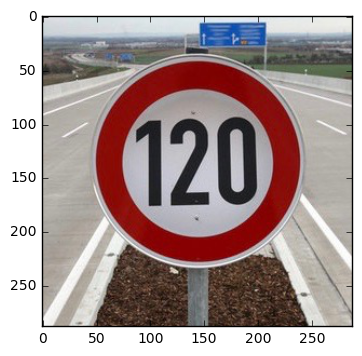

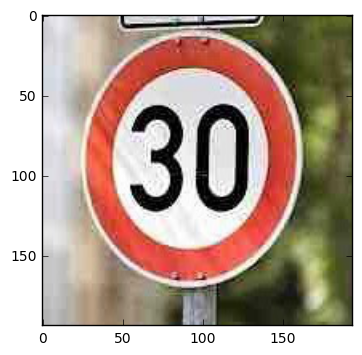

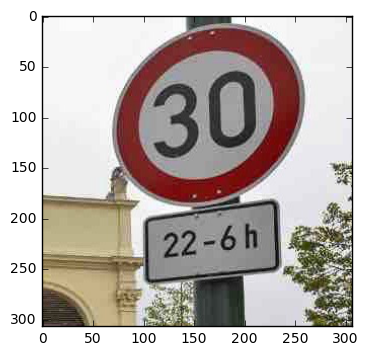

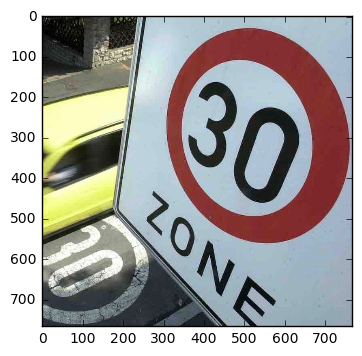

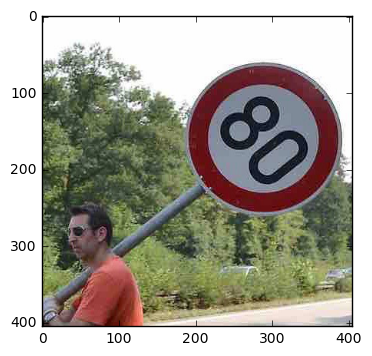

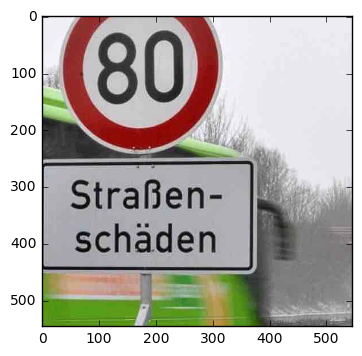

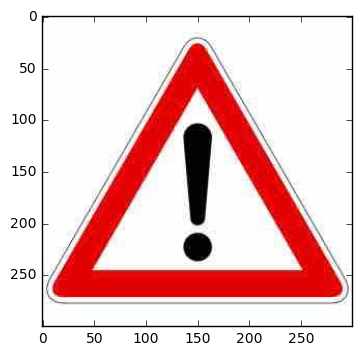

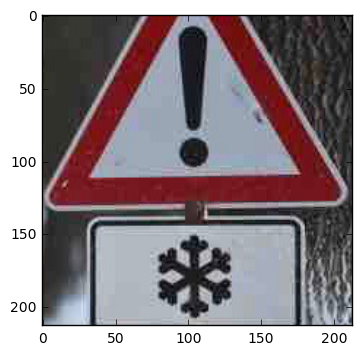

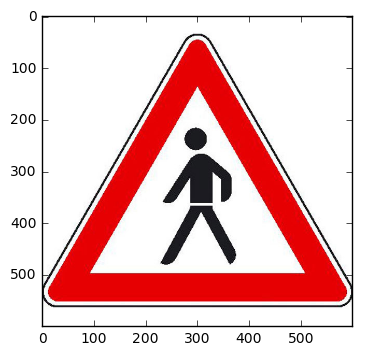

In [19]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os, json

path_to_jpg = './img_internet/'
jpg_files = [pos_jpg for pos_jpg in os.listdir(path_to_jpg) if pos_jpg.endswith('.jpg')]
print(jpg_files)

img_internet = []

for img in jpg_files:
    plt.figure()
    img = cv2.imread(os.path.join(path_to_jpg, img))
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    
    #Resize to 32x32x3
    res = cv2.resize(cv_rgb,(32, 32), interpolation = cv2.INTER_AREA)
    #normalization
    norm_res = normalize_image(res)
    
    img_internet.append(norm_res)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

- Traffic sign turned sidewards.
- Traffic sign to small / big
- Combination of signs
- different camera angel
- Traffic sign not in Testset

In [20]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "./traffic-sign-model_v2.ckpt")
    print("Model restored.")
    # Do some work with the model
    classification = sess.run(tf.argmax(logits, 1), feed_dict={x: img_internet, keep_prob: 1.})
    print(classification)


Model restored.
[12  8  1 12 40 12 29 18  9 27]


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

The Model does get a lot of images correct, but the performance in percentage is not as good. This might be because of different sizes of the images or different angles of view.
If we would transform every sign plain and scale to the right size it might work.

Model restored.


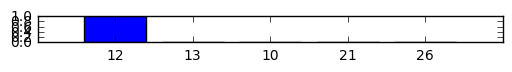

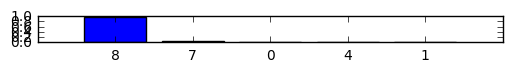

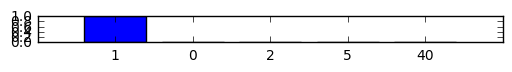

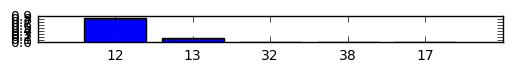

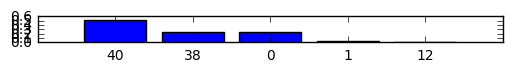

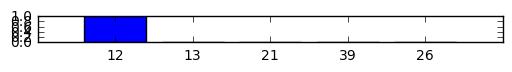

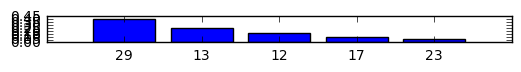

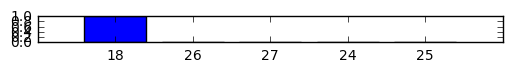

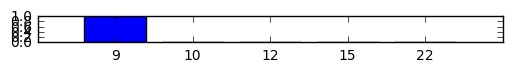

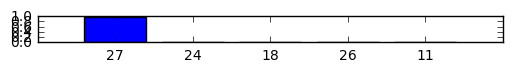

In [21]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "./traffic-sign-model_v2.ckpt")
    print("Model restored.")
    # Do some work with the model
    softmax = sess.run(tf.nn.softmax(logits), feed_dict={x: img_internet, keep_prob: 1.})
    top_5,ind = tf.nn.top_k(softmax, k = 5)
    top_5 = top_5.eval()
    ind = ind.eval()
    i=0
    for el in range(len(top_5)):
        i+=1
        plt.subplot(10,1,i)
        plt.bar(range(len(top_5[el])), top_5[el], align='center')
        plt.xticks(range(len(ind[el])), ind[el])
        plt.show()



### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

Most of the predictions the model is certain of. Even if the predicted sign is wrong.

In cases, where the probabilities where not certain, the correct ones were not in the top 5 either.


### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

- New pictures ar resized to 32x32x3 images.
- Pictures need to be normalized.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.